<a href="https://colab.research.google.com/github/juanignaciogiacobbe/7506R-2C2023-GRUPO15/blob/main/7506R_TP2_GRUPO15_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2: Cinematográficas</center>
### <center> Grupo número 15</center>
### <center> Giacobbe, Juan Ignacio; Olaran, Sebastian; Ayala, Tomás</center>

Instalamos e importamos las librerías que vamos a utilizar

In [1]:
!pip install keras==2.12.0
!pip uninstall tensorflow -y
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 2.12.0 which is incompatible.
Found existing installation: tensorflow 2.14.0
Uninstalling tensorflow-2.14.0:
  Successfully uninstalled tensorflow-2.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorf

In [2]:
import nltk
nltk.download('stopwords')
stopwords_es = nltk.corpus.stopwords.words('spanish')
import re
from unicodedata import normalize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#Para análisis de los datos
import pandas as pd
import numpy as np

#Para visualizaciones
import seaborn as sns
from matplotlib import pyplot as plt

#Creación de redes neuronales
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, precision_score, recall_score, accuracy_score,f1_score
from sklearn.decomposition import PCA

import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier

#Creación de XGBoost
from xgboost import XGBClassifier
import xgboost as xgb

In [4]:
#Declaro constantes
SEED = 15

np.random.seed(SEED)
tf.random.set_seed(SEED)

#Exploración y preprocesamiento de los datasets
Importamos los archivos

In [5]:
reviews_test = pd.read_csv('./test.csv')
reviews_train = pd.read_csv('./train.csv')

ds_cine_train = reviews_train.copy()
ds_cine_test = reviews_test.copy()

Veamos las dimensiones de cada uno

In [6]:
ds_cine_train.shape

(50000, 3)

Tenemos para el dataset de entrenamiento 50000 registros de críticas, cada una con 3 campos.

Ahora, veamos sus columnas

In [ ]:
ds_cine_train.columns.to_list()

Vemos que hay una columna que tiene el ID de la review, pero no la vamos a necesitar ni para predecir ni para hacer los submits a la competencia(no nos interesa eso para entrenar los modelos), por lo que procedemos a eliminar esa columna del dataset

In [7]:
ds_cine_train.drop(['ID'], axis=1, inplace=True)

In [ ]:
ds_cine_train

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,Voy a tener que estar en desacuerdo con el com...,negativo


Veamos el dataset de test

In [ ]:
ds_cine_test.shape

(8599, 2)

Vemos que el dataset de test tiene 8599 registros para predecir. Vamos a tener que predecir con nuestros modelos predictivos la variable "sentimiento", que a partir de ahora la llamaremos "variable target".

In [ ]:
ds_cine_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


No eliminaremos la columna de ID para este dataset porque la necesitamos para subir nuestras predicciones a Kaggle.

Tratemos de encontrar datos faltantes en ambos datasets. Si esto ocurre, debemos seguir preprocesando los datasets

In [ ]:
print(ds_cine_train.isna().sum())

review_es      0
sentimiento    0
dtype: int64


Vemos que el dataset de train NO tiene datos faltantes, por lo que procedemos a hacer lo mismo pero con el dataset de test

In [ ]:
print(ds_cine_test.isna().sum())

ID           0
review_es    0
dtype: int64


Este dataset tampoco tiene datos faltantes.

In [ ]:
ds_cine_train['sentimiento'].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64



---


#Separación del dataset de entrenamiento y algunas transformaciones

In [9]:
features = ['review_es']

target = 'sentimiento'

Separamos el dataset de entrenamiento en un subconjunto de train y otro de test

In [12]:
#Separo un set de Evaluacion
from sklearn.model_selection import train_test_split

#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = ds_cine_train.drop([target], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = ds_cine_train[target].copy()


x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size = 0.3,    #30% al conjunto de test
                                                    random_state = SEED,  #para poder reproducir el experimento
                                                    stratify=ds_cine_train[target].values) #estratificado para mantener proporcion

###Transformación de Datos

Para utilizar este modelo, se nos pide que los datos sean numéricos, por lo que vamos a tomar los registros de la variable target en el dataset de train, y los vamos a binarizar usando un Label Encoder.

In [13]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

Una vez que tenemos la variable binarizada, comenzamos a entrenar nuestros modelos XGBoost y Redes Neuronales. Estos modelos van a predecir la variable target en forma binaria, por lo que por cada predicción vamos a tener que volver a transformar los datos, pero ahora de manera inversa: pasaremos de tener una variable con valores binarios a una variable con valores del tipo "string"(obviamente, solo podrá tomar el valor "positivo" o "negativo", que es lo que buscamos).



---


# Modelo Bayes Naïve


Para este modelo, lo que haremos será crear un Pipeline entre un Modelo Multinomial de Bayes Naïve con un Tfid Vectorizer. Este último se encargará de vectorizar y tokenizar nuestro dataset de reseñas, mientras que el modelo predictivo se encargará de predecir las reseñas correspondientes.

##Primer modelo

Para este primer modelo crearemos el Pipeline pero no utilizaremos ninguna optimización de hiperparámetros, para familiarizarnos con la creación de estos modelos, y para ver la performance que tienen con los hiperparámetros que vienen por defecto.

In [ ]:
modeloBayesNaive = make_pipeline(TfidfVectorizer(), MultinomialNB())
modeloBayesNaive.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
y_pred=modeloBayesNaive.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.850003376781252

              precision    recall  f1-score   support

    negativo       0.84      0.86      0.85      7500
    positivo       0.86      0.84      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'y_pred')

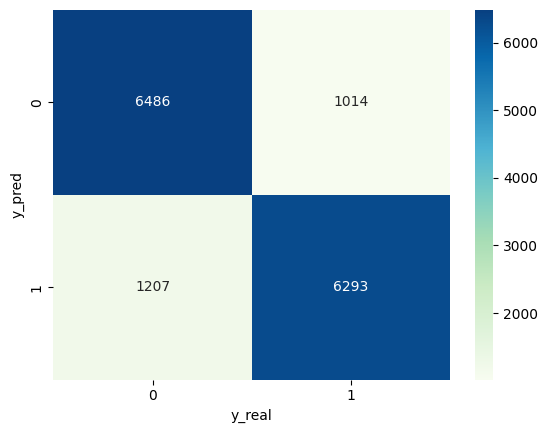

In [ ]:
y_pred = modeloBayesNaive.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modeloBayesNaive.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4435
negativo    4164
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_bayes2.csv", index = False)

##Segundo modelo

Ahora, para este modelo vamos a comenzar con la optimización de hiperparámetros utilizando Cross Validation. Además, utilizaremos el algoritmo de Random Search para optimizarlos, utilizando 7 folds, y realizando 36 iteraciones.

In [ ]:
alpha = [0.1, 0.5, 1.0]
fit_prior = [True, False]
class_prior = [None, [0.2, 0.8], [0.5, 0.5]]

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

param_grid = {
  'tfidfvectorizer__stop_words': ['english', None],
  'multinomialnb__alpha': alpha,
  'multinomialnb__fit_prior': fit_prior,
  'multinomialnb__class_prior': class_prior
}

# Configurar GridSearchCV
random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=7, scoring='accuracy', verbose=2, n_iter = 36)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 7 folds for each of 36 candidates, totalling 252 fits
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=  11.9s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=   9.7s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=   9.7s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=   9.7s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=   8.7s
[CV] END multinomialnb__alpha=0.1, multinomialnb__class_prior=None, multinomialnb__fit_prior=True, tfidfvectorizer__stop_words=english; total time=   9.9s
[CV] END

In [ ]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer( stop_words=random_search.best_params_['tfidfvectorizer__stop_words'],
                                             )),
        ('multinomialnb', MultinomialNB(alpha = random_search.best_params_['multinomialnb__alpha'],
                                        fit_prior = random_search.best_params_['multinomialnb__fit_prior'],
                                        class_prior= random_search.best_params_['multinomialnb__class_prior']))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB(alpha=0.5))])

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8556624722427832

              precision    recall  f1-score   support

    negativo       0.85      0.87      0.86      7500
    positivo       0.86      0.85      0.86      7500

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



Text(50.722222222222214, 0.5, 'y_pred')

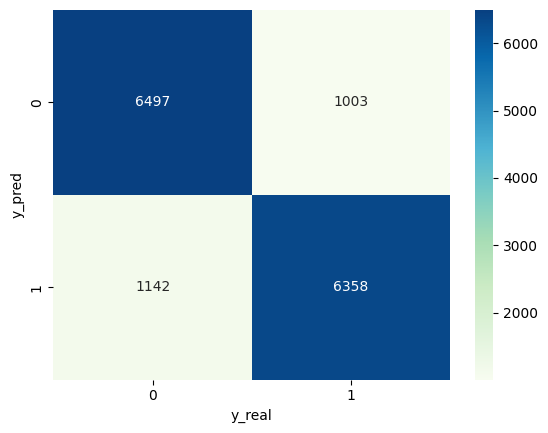

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4630
negativo    3969
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_bayes6.csv", index = False)

##Tercer modelo

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
fit_prior = [True, False]
class_prior = [None, [0.2, 0.8], [0.5, 0.5]]

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('multinomialnb', MultinomialNB())])

param_grid = {
  'tfidfvectorizer__stop_words': ['english', None],
  'multinomialnb__alpha': alpha,
  'multinomialnb__fit_prior': fit_prior,
  'multinomialnb__class_prior': class_prior
}

# Configurar GridSearchCV
random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=10, scoring='roc_auc', verbose=2, n_iter = 50)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; total time=  16.0s
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; total time=   9.9s
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; total time=  11.1s
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; total time=  15.7s
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; total time=   8.8s
[CV] END multinomialnb__alpha=0.0001, multinomialnb__class_prior=None, multinomialnb__fit_prior=False, tfidfvectorizer__stop_words=english; to

In [ ]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer( stop_words=random_search.best_params_['tfidfvectorizer__stop_words'],
                                             )),
        ('multinomialnb', MultinomialNB(alpha = random_search.best_params_['multinomialnb__alpha'],
                                        fit_prior = random_search.best_params_['multinomialnb__fit_prior'],
                                        class_prior= random_search.best_params_['multinomialnb__class_prior']))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb',
                 MultinomialNB(alpha=1, class_prior=[0.2, 0.8],
                               fit_prior=False))])

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.7490343616754452

              precision    recall  f1-score   support

    negativo       0.99      0.34      0.50      7500
    positivo       0.60      1.00      0.75      7500

    accuracy                           0.67     15000
   macro avg       0.79      0.67      0.63     15000
weighted avg       0.79      0.67      0.63     15000



Text(50.722222222222214, 0.5, 'y_pred')

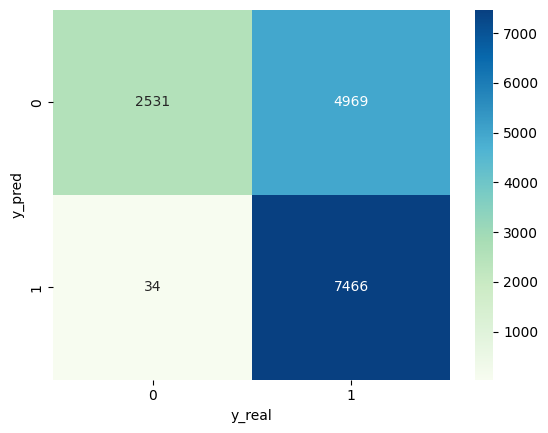

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    8427
negativo     172
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,positivo
60001,positivo
60002,positivo
60003,positivo
60004,positivo
...,...
68594,positivo
68595,positivo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_bayes.csv", index = False)



---



# Modelo Random forest

##Primer modelo

Para este primer modelo crearemos el Pipeline pero no utilizaremos ninguna optimización de hiperparámetros, para familiarizarnos con la creación de estos modelos, y para ver la performance que tienen con los hiperparámetros que vienen por defecto.

In [ ]:
modelo = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.829523362606422

              precision    recall  f1-score   support

    negativo       0.83      0.84      0.83      7500
    positivo       0.83      0.82      0.83      7500

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

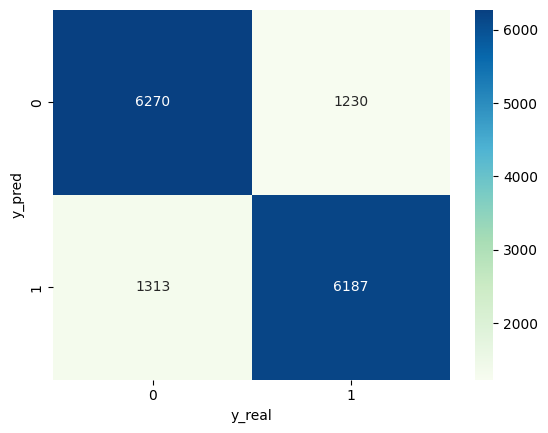

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4869
negativo    3730
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_rf1.csv", index = False)

## Segundo modelo

In [ ]:
n_estimators = np.arange(50, 201, 10)
max_depth = np.arange(10, 31)
min_samples_leaf = np.arange(1, 5)
min_samples_split = np.arange(2, 11)
criterion = ['gini', 'entropy']
oob_score = [True, False]

gsrf = RandomForestClassifier(class_weight="balanced")

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('gsrf', gsrf)])

param_grid = {
  'gsrf__n_estimators': n_estimators,
  'gsrf__max_depth': max_depth,
  'gsrf__min_samples_leaf': min_samples_leaf,
  'gsrf__min_samples_split': min_samples_split,
  'gsrf__criterion': criterion,
  'gsrf__oob_score': oob_score
}

# Configurar GridSearchCV
random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=10, n_iter = 25, scoring='accuracy', verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_split=2, gsrf__n_estimators=90, gsrf__oob_score=True; total time=  32.2s
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_split=2, gsrf__n_estimators=90, gsrf__oob_score=True; total time=  23.6s
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_split=2, gsrf__n_estimators=90, gsrf__oob_score=True; total time=  23.3s
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_split=2, gsrf__n_estimators=90, gsrf__oob_score=True; total time=  23.6s
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_split=2, gsrf__n_estimators=90, gsrf__oob_score=True; total time=  24.0s
[CV] END gsrf__criterion=gini, gsrf__max_depth=28, gsrf__min_samples_leaf=3, gsrf__min_samples_sp

In [ ]:
modelo = Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer()),
        ('gsrf', RandomForestClassifier(class_weight="balanced",
                                        oob_score = random_search.best_params_['gsrf__oob_score'],
                                        n_estimators= random_search.best_params_['gsrf__n_estimators'],
                                        min_samples_split= random_search.best_params_['gsrf__min_samples_split'],
                                        min_samples_leaf= random_search.best_params_['gsrf__min_samples_leaf'],
                                        max_depth= random_search.best_params_['gsrf__max_depth'],
                                        criterion= random_search.best_params_['gsrf__criterion'],))
    ])

modelo.fit(x_train.review_es, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('gsrf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=29,
                                        min_samples_leaf=4, min_samples_split=7,
                                        n_estimators=140, oob_score=True))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8310331484586612

              precision    recall  f1-score   support

    negativo       0.85      0.79      0.82      7500
    positivo       0.80      0.86      0.83      7500

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

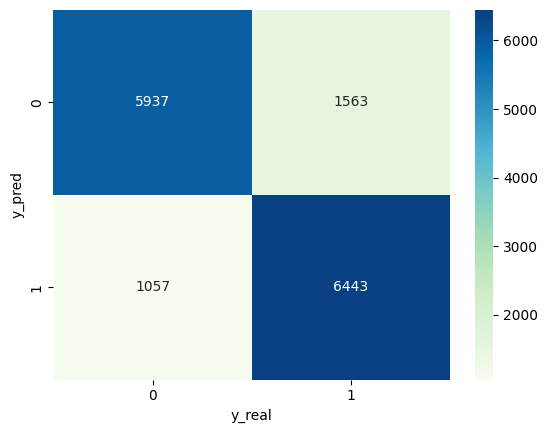

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

NotFittedError: ignored

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_rf6.csv", index = False)

## Tercer modelo

In [ ]:
n_estimators = [40, 50, 80]
max_depth = np.arange(5, 31)
min_samples_leaf = [15, 30, 60]
min_samples_split = [40, 50, 60]
criterion = ['gini', 'entropy']
oob_score = [True, False]
bootstrap = [True]


gsrf = RandomForestClassifier(class_weight="balanced")

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('gsrf', gsrf)])

param_grid = {
  'gsrf__n_estimators': n_estimators,
  'gsrf__max_depth': max_depth,
  'gsrf__min_samples_leaf': min_samples_leaf,
  'gsrf__min_samples_split': min_samples_split,
  'gsrf__criterion': criterion,
  'gsrf__oob_score': oob_score,
  'gsrf__bootstrap': bootstrap,

}

random_search = RandomizedSearchCV(estimator = modelo, param_distributions = param_grid, cv=5, n_iter = 100, scoring='f1', verbose=2, random_state=SEED)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END gsrf__bootstrap=True, gsrf__criterion=gini, gsrf__max_depth=14, gsrf__min_samples_leaf=30, gsrf__min_samples_split=60, gsrf__n_estimators=50, gsrf__oob_score=True; total time=  25.6s
[CV] END gsrf__bootstrap=True, gsrf__criterion=gini, gsrf__max_depth=14, gsrf__min_samples_leaf=30, gsrf__min_samples_split=60, gsrf__n_estimators=50, gsrf__oob_score=True; total time=  11.7s
[CV] END gsrf__bootstrap=True, gsrf__criterion=gini, gsrf__max_depth=14, gsrf__min_samples_leaf=30, gsrf__min_samples_split=60, gsrf__n_estimators=50, gsrf__oob_score=True; total time=  15.7s
[CV] END gsrf__bootstrap=True, gsrf__criterion=gini, gsrf__max_depth=14, gsrf__min_samples_leaf=30, gsrf__min_samples_split=60, gsrf__n_estimators=50, gsrf__oob_score=True; total time=  16.0s
[CV] END gsrf__bootstrap=True, gsrf__criterion=gini, gsrf__max_depth=14, gsrf__min_samples_leaf=30, gsrf__min_samples_split=60, gsrf__n_estimators=50, gsrf__oob_score=Tr

In [ ]:
modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer(

    )),
    ('gsrf', RandomForestClassifier(
        class_weight="balanced",
        oob_score=random_search.best_params_['gsrf__oob_score'],
        n_estimators=random_search.best_params_['gsrf__n_estimators'],
        min_samples_split=random_search.best_params_['gsrf__min_samples_split'],
        min_samples_leaf=random_search.best_params_['gsrf__min_samples_leaf'],
        max_depth=random_search.best_params_['gsrf__max_depth'],
        criterion=random_search.best_params_['gsrf__criterion'],
        bootstrap=random_search.best_params_['gsrf__bootstrap']

    ))
])

modelo.fit(x_train.review_es, y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('gsrf',
                 RandomForestClassifier(class_weight='balanced', max_depth=28,
                                        min_samples_leaf=15,
                                        min_samples_split=50, n_estimators=80,
                                        oob_score=True))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8250773993808049

              precision    recall  f1-score   support

    negativo       0.84      0.79      0.81      7500
    positivo       0.80      0.85      0.83      7500

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000



Text(50.722222222222214, 0.5, 'y_pred')

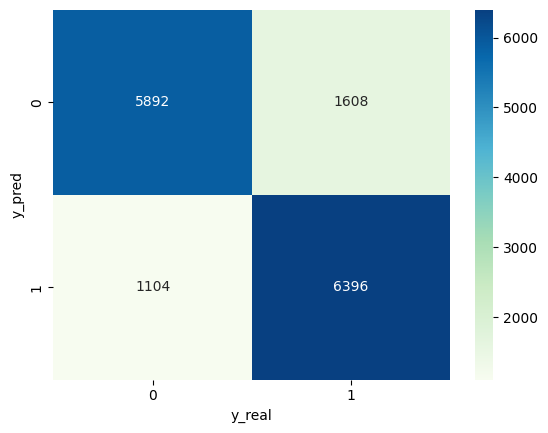

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    5352
negativo    3247
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,positivo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_rf.csv", index = False)



---



# Modelo XGBoost


###Transformación de Datos

Para utilizar este modelo, se nos pide que los datos sean numéricos, por lo que vamos a tomar los registros de la variable target en el dataset de train, y los vamos a binarizar usando un Label Encoder.

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

Una vez que tenemos la variables binarizada, comenzamos a entrenar nuestros modelos XGBoost. El modelo va a predecir la variable target en forma binaria, por lo que por cada predicción vamos a tener que volver a transformar los datos, pero ahora de manera inversa: pasaremos de tener una variable con valores binarios a una variable con valores del tipo "string"(obviamente, solo podrá tomar el valor "positivo" o "negativo", que es lo que buscamos).

##Primer modelo

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [ ]:
modelo = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier())
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8443950875359288

              precision    recall  f1-score   support

    negativo       0.86      0.82      0.84      7500
    positivo       0.83      0.86      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'y_pred')

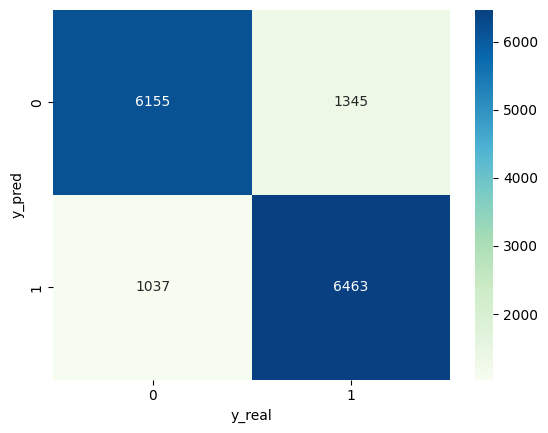

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4755
negativo    3844
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost2.csv", index = False)

## Segundo Modelo


In [ ]:
n_estimators = np.arange(50, 201, 10)
max_depth = np.arange(3, 7)
min_child_weight = np.arange(1, 5)
colsample_bytree = np.arange(0.6, 1.1, 0.1)
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
gamma = np.arange(0.0, 0.2, 0.05)
reg_alpha = np.arange(0.0, 0.2, 0.05)
reg_lambda = np.arange(0.0, 0.2, 0.05)

# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
    'xgboost_model__reg_alpha': reg_alpha,
    'xgboost_model__reg_lambda': reg_lambda
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=5, scoring='accuracy',
                                   verbose=2)

# Assuming y_train contains 'negativo' and 'positivo'
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.5min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.6min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05,

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/s

Mejor conjunto de hiperparámetros encontrado:
{'xgboost_model__subsample': 0.9, 'xgboost_model__reg_lambda': 0.0, 'xgboost_model__reg_alpha': 0.0, 'xgboost_model__n_estimators': 190, 'xgboost_model__min_child_weight': 2, 'xgboost_model__max_depth': 3, 'xgboost_model__learning_rate': 0.3, 'xgboost_model__gamma': 0.05, 'xgboost_model__colsample_bytree': 0.8999999999999999}
Mejor puntuación de validación cruzada:
0.8399142857142857


In [ ]:
modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=random_search.best_params_['xgboost_model__n_estimators'],
                                    max_depth=random_search.best_params_['xgboost_model__max_depth'],
                                    colsample_bytree=random_search.best_params_['xgboost_model__colsample_bytree'],
                                    learning_rate=random_search.best_params_['xgboost_model__learning_rate'],
                                    gamma=random_search.best_params_['xgboost_model__gamma'],
                                    reg_alpha=random_search.best_params_['xgboost_model__reg_alpha'],
                                    reg_lambda=random_search.best_params_['xgboost_model__reg_lambda'],
                                    subsample=random_search.best_params_['xgboost_model__subsample'],
                                    )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8999999999999999, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8493346316131127

              precision    recall  f1-score   support

    negativo       0.86      0.82      0.84      7500
    positivo       0.83      0.87      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'y_pred')

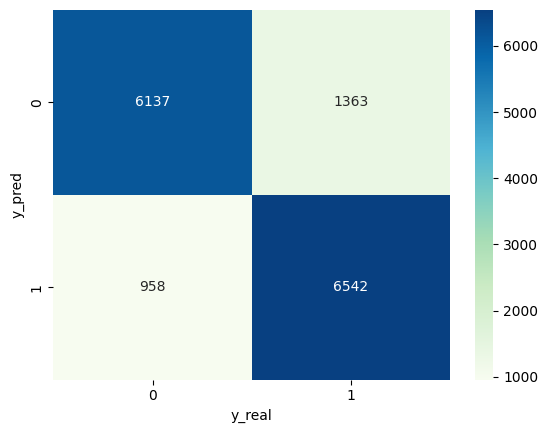

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4947
negativo    3652
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost3.csv", index = False)

## Tercer Modelo


In [ ]:
n_estimators = np.arange(50, 201, 10)
max_depth = np.arange(3, 7)
min_child_weight = np.arange(1, 5)
colsample_bytree = np.arange(0.6, 1.1, 0.1)
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
gamma = np.arange(0.0, 0.2, 0.05)
reg_alpha = np.arange(0.0, 0.2, 0.05)
reg_lambda = np.arange(0.0, 0.2, 0.05)

# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
    'xgboost_model__reg_alpha': reg_alpha,
    'xgboost_model__reg_lambda': reg_lambda
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=30, scoring='f1',
                                   verbose=2)

# Assuming y_train contains 'negativo' and 'positivo'
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Now, y_train_encoded will contain 0s and 1s, suitable for binary classification

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.6min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.5min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboos

Mejor conjunto de hiperparámetros encontrado:
{'xgboost_model__subsample': 1.0, 'xgboost_model__reg_lambda': 0.1, 'xgboost_model__reg_alpha': 0.0, 'xgboost_model__n_estimators': 190, 'xgboost_model__min_child_weight': 4, 'xgboost_model__max_depth': 6, 'xgboost_model__learning_rate': 0.3, 'xgboost_model__gamma': 0.15000000000000002, 'xgboost_model__colsample_bytree': 0.6}
Mejor puntuación de validación cruzada:
0.8506389279034663


In [ ]:
modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=random_search.best_params_['xgboost_model__n_estimators'],
                                    max_depth=random_search.best_params_['xgboost_model__max_depth'],
                                    colsample_bytree=random_search.best_params_['xgboost_model__colsample_bytree'],
                                    learning_rate=random_search.best_params_['xgboost_model__learning_rate'],
                                    gamma=random_search.best_params_['xgboost_model__gamma'],
                                    reg_alpha=random_search.best_params_['xgboost_model__reg_alpha'],
                                    reg_lambda=random_search.best_params_['xgboost_model__reg_lambda'],
                                    subsample=random_search.best_params_['xgboost_model__subsample'],
                                    )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.15000000000000002,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8508098891730606

              precision    recall  f1-score   support

    negativo       0.86      0.83      0.85      7500
    positivo       0.84      0.86      0.85      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'y_pred')

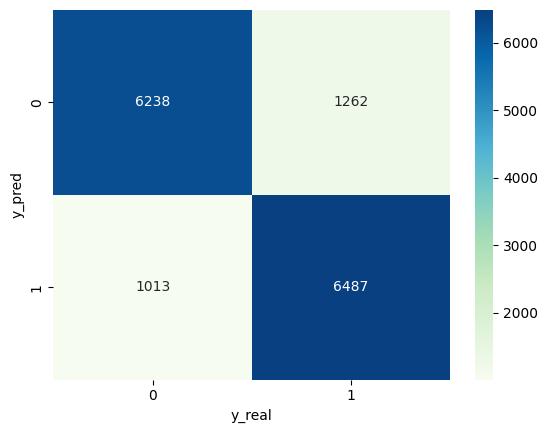

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4850
negativo    3749
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost4.csv", index = False)

## Cuarto Modelo


In [ ]:
n_estimators = np.arange(50, 201, 10)
max_depth = np.arange(3, 7)
min_child_weight = np.arange(1, 5)
colsample_bytree = np.arange(0.6, 1.1, 0.1)
learning_rate = [0.01, 0.1, 0.2, 0.3]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
gamma = np.arange(0.0, 0.2, 0.05)
reg_alpha = np.arange(0.0, 0.2, 0.05)
reg_lambda = np.arange(0.0, 0.2, 0.05)

# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
    'xgboost_model__reg_alpha': reg_alpha,
    'xgboost_model__reg_lambda': reg_lambda
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=30, scoring='f1',
                                   verbose=2)

# Assuming y_train contains 'negativo' and 'positivo'
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Now, y_train_encoded will contain 0s and 1s, suitable for binary classification

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.6min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.05, xgboost_model__subsample=0.9; total time= 3.5min
[CV] END xgboost_model__colsample_bytree=0.8999999999999999, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=4, xgboost_model__min_child_weight=1, xgboost_model__n_estimators=190, xgboost_model__reg_alpha=0.0, xgboost_model__reg_lambda=0.0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboos

Mejor conjunto de hiperparámetros encontrado:
{'xgboost_model__subsample': 1.0, 'xgboost_model__reg_lambda': 0.1, 'xgboost_model__reg_alpha': 0.0, 'xgboost_model__n_estimators': 190, 'xgboost_model__min_child_weight': 4, 'xgboost_model__max_depth': 6, 'xgboost_model__learning_rate': 0.3, 'xgboost_model__gamma': 0.15000000000000002, 'xgboost_model__colsample_bytree': 0.6}
Mejor puntuación de validación cruzada:
0.8506389279034663


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

best_params = {
    'xgboost_model__subsample': 1.0,
    'xgboost_model__reg_lambda': 0.1,
    'xgboost_model__reg_alpha': 0.1,
    'xgboost_model__n_estimators': 190,
    'xgboost_model__min_child_weight': 4,
    'xgboost_model__max_depth': 6,
    'xgboost_model__learning_rate': 0.3,
    'xgboost_model__gamma': 0.15,
    'xgboost_model__colsample_bytree': 0.6,
    'xgboost_model__scale_pos_weight': 1,
    'xgboost_model__max_delta_step': 0,
    'xgboost_model__colsample_bylevel': 1,
    'xgboost_model__colsample_bynode': 1,
    'xgboost_model__silent': False,
    'xgboost_model__objective': 'reg:squarederror',
    'xgboost_model__eval_metric': 'rmse',
    'xgboost_model__booster': 'gbtree',
    'xgboost_model__seed': 42
}


modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(**best_params)),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:48:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "xgboost_model__booster", "xgboost_model__colsample_bylevel", "xgboost_model__colsample_bynode", "xgboost_model__colsample_bytree", "xgboost_model__eval_metric", "xgboost_model__gamma", "xgboost_model__learning_rate", "xgboost_model__max_delta_step", "xgboost_model__max_depth", "xgboost_model__min_child_weight", "xgboost_model__n_estimators", "xgboost_model__objective", "xgboost_model__reg_alpha", "xgboost_model__reg_lambda", "xgboost_model__scale_pos_weight", "xgboost_model__seed", "xgboost_model__silent", "xgboost_model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8443950875359288

              precision    recall  f1-score   support

    negativo       0.86      0.82      0.84      7500
    positivo       0.83      0.86      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'y_pred')

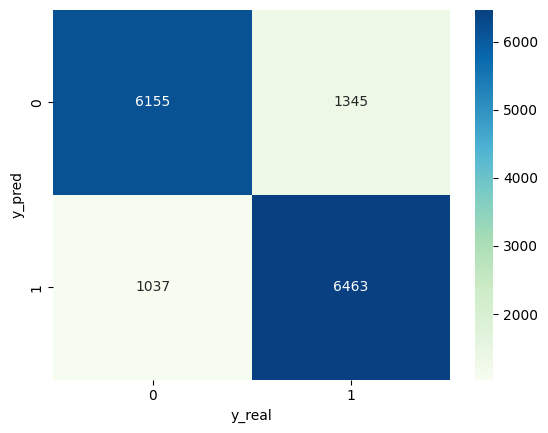

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4755
negativo    3844
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost8.csv", index = False)

## Quinto Modelo


In [ ]:
n_estimators = np.arange(90, 110, 10)
max_depth = np.arange(7, 11)
min_child_weight = np.arange(1, 3)
colsample_bytree = np.arange(0.3, 0.5, 0.1)
learning_rate = [0.01, 0.1]
subsample = [0.6, 0.7]
gamma = np.arange(0.0, 0.1, 0.05)


# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy',
                                   verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.1min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboo

In [ ]:
modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators= 90 ,
                                    max_depth=10,
                                    colsample_bytree=0.4,
                                    learning_rate=0.1,
                                    gamma=0.05,
                                    subsample=0.7,
                                    )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.4, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=90, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8325011348161597

              precision    recall  f1-score   support

    negativo       0.85      0.80      0.82      7500
    positivo       0.81      0.86      0.83      7500

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

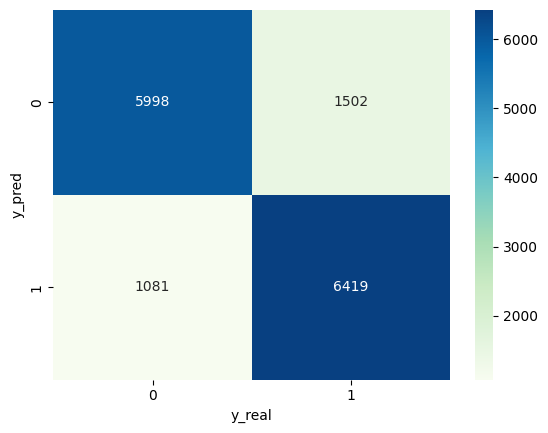

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4803
negativo    3796
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,positivo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost9.csv", index = False)

## Sexto Modelo() jugando con las regularizaciones

In [ ]:
n_estimators = np.arange(90, 110, 10)
max_depth = np.arange(7, 11)
min_child_weight = np.arange(1, 3)
colsample_bytree = np.arange(0.3, 0.5, 0.1)
learning_rate = [0.01, 0.1]
subsample = [0.6, 0.7]
gamma = np.arange(0.0, 0.1, 0.05)


# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy',
                                   verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.1min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboo

In [ ]:

modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=190,
                                max_depth=6,
                                colsample_bytree=0.6,
                                learning_rate=0.3,
                                gamma=0.5,
                                reg_alpha=0.5,  # Puedes ajustar estos valores
                                reg_lambda=0.5,  # Puedes ajustar estos valores
                                )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8568618451249097

              precision    recall  f1-score   support

    negativo       0.87      0.84      0.85      7500
    positivo       0.84      0.87      0.86      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



Text(50.722222222222214, 0.5, 'y_pred')

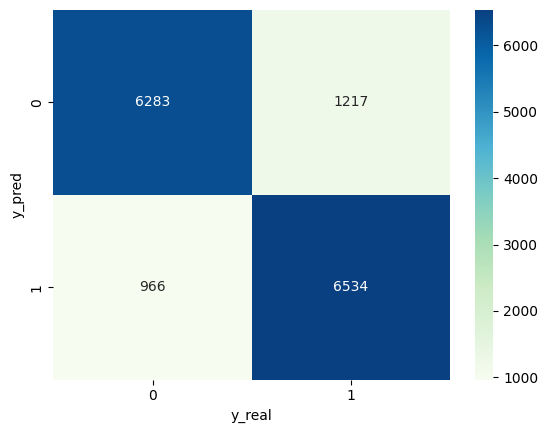

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4804
negativo    3795
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,positivo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost12.csv", index = False)

## Septimo Modelo() jugando con las regularizaciones,falta kaggle

In [ ]:
n_estimators = np.arange(90, 110, 10)
max_depth = np.arange(7, 11)
min_child_weight = np.arange(1, 3)
colsample_bytree = np.arange(0.3, 0.5, 0.1)
learning_rate = [0.01, 0.1]
subsample = [0.6, 0.7]
gamma = np.arange(0.0, 0.1, 0.05)


# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy',
                                   verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.1min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboo

In [ ]:

modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=190,
                                max_depth=6,
                                colsample_bytree=0.6,
                                learning_rate=0.1,
                                gamma=0.15,
                                reg_alpha=1,  # Puedes ajustar estos valores
                                reg_lambda=1,  # Puedes ajustar estos valores
                                )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.15, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8403938333981086

              precision    recall  f1-score   support

    negativo       0.86      0.81      0.83      7500
    positivo       0.82      0.86      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'y_pred')

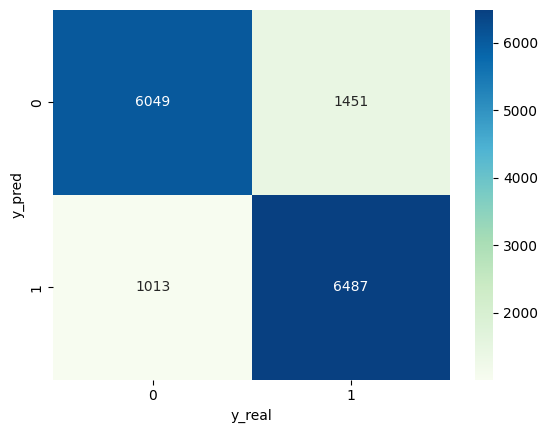

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4816
negativo    3783
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost13.csv", index = False)

## Octavo Modelo() jugando con las regularizaciones,falta kaggle

In [ ]:
n_estimators = np.arange(90, 110, 10)
max_depth = np.arange(7, 11)
min_child_weight = np.arange(1, 3)
colsample_bytree = np.arange(0.3, 0.5, 0.1)
learning_rate = [0.01, 0.1]
subsample = [0.6, 0.7]
gamma = np.arange(0.0, 0.1, 0.05)


# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy',
                                   verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.1min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboo

In [ ]:

modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=190,
                                max_depth=6,
                                colsample_bytree=0.6,
                                learning_rate=0.1,
                                gamma=0.15,
                                reg_alpha=2,  # Puedes ajustar estos valores
                                reg_lambda=2,  # Puedes ajustar estos valores
                                )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.15, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8413498836307215

              precision    recall  f1-score   support

    negativo       0.86      0.81      0.83      7500
    positivo       0.82      0.87      0.84      7500

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'y_pred')

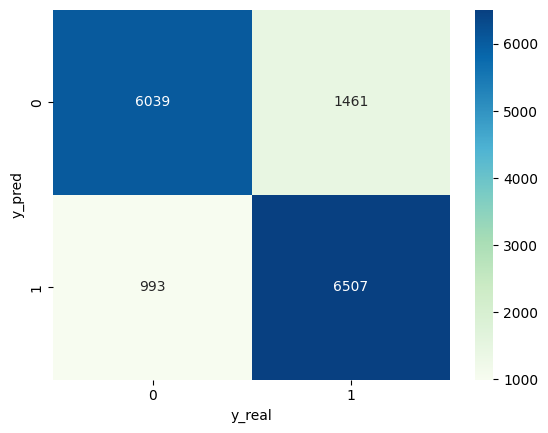

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4768
negativo    3831
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost14.csv", index = False)

## NovenoModelo() jugando con las regularizaciones,falta kaggle

In [ ]:
n_estimators = np.arange(90, 110, 10)
max_depth = np.arange(7, 11)
min_child_weight = np.arange(1, 3)
colsample_bytree = np.arange(0.3, 0.5, 0.1)
learning_rate = [0.01, 0.1]
subsample = [0.6, 0.7]
gamma = np.arange(0.0, 0.1, 0.05)


# Using XGBClassifier
xgboost_model = xgb.XGBClassifier()

modelo = Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('xgboost_model', xgboost_model)])

param_grid = {
    'xgboost_model__subsample': subsample,
    'xgboost_model__n_estimators': n_estimators,
    'xgboost_model__max_depth': max_depth,
    'xgboost_model__min_child_weight': min_child_weight,
    'xgboost_model__colsample_bytree': colsample_bytree,
    'xgboost_model__learning_rate': learning_rate,
    'xgboost_model__gamma': gamma,
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=5, n_iter=10, scoring='accuracy',
                                   verbose=2)

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train.review_es, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.3min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboost_model__n_estimators=100, xgboost_model__subsample=0.6; total time= 6.1min
[CV] END xgboost_model__colsample_bytree=0.4, xgboost_model__gamma=0.05, xgboost_model__learning_rate=0.01, xgboost_model__max_depth=10, xgboost_model__min_child_weight=2, xgboo

In [ ]:

modelo = Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=190,
                                max_depth=6,
                                colsample_bytree=0.6,
                                learning_rate=0.1,
                                gamma=0.15,
                                reg_alpha=5,  # Puedes ajustar estos valores
                                reg_lambda=5,  # Puedes ajustar estos valores
                                )),
])

# Transform x_train.review_es using TfidfVectorizer and fit the model
modelo.fit(x_train.review_es, y_train_encoded)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgboost_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.15, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=190, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred=modelo.predict(x_test.review_es)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, pos_label='positivo')

0.8364649475184658

              precision    recall  f1-score   support

    negativo       0.85      0.80      0.83      7500
    positivo       0.81      0.86      0.84      7500

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

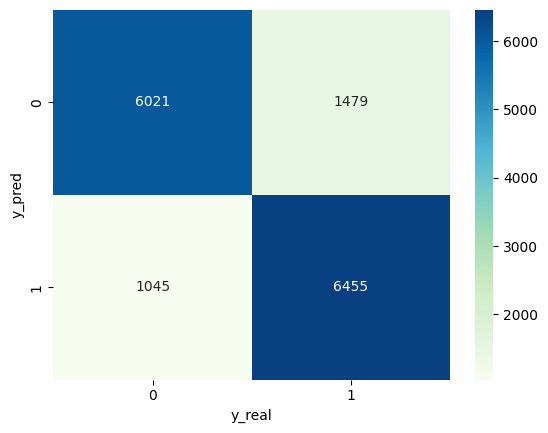

In [ ]:
y_pred = modelo.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4767
negativo    3832
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,positivo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_xgboost15.csv", index = False)



---


#Modelo Red Neuronal

In [ ]:
frasesFiltradas = []
for index, value in ds_cine_train["review_es"].items():
  #Ponemos todas las palabras en lowercase
  value = value.lower()

  #Saco las stopwords
  valueFiltrado = [x for x in value.split() if x not in stopwords_es]
        #Vuelvo a unir el texto
  valueFiltrado = " ".join(valueFiltrado)

  #Saca los diacriticos de letras como vocales, etc (la ñ se mantiene)
  #Expresion regular obtenida de: https://es.stackoverflow.com/a/139811
  valueFiltrado = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
                                normalize( "NFD", valueFiltrado), 0, re.I)
  valueFiltrado = normalize('NFC', valueFiltrado)

  #Saco los signos de puntuacion
  #Funcion obtenida de: https://stackoverflow.com/a/266162/13683575
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', string.punctuation))
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¡'))
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¿'))

  #Anadimos la frase a la lista de frases filtradas
  frasesFiltradas.append(valueFiltrado)
reviewDfFiltrado = pd.DataFrame(data={'review_es':frasesFiltradas, 'sentimiento':ds_cine_train['sentimiento']})

In [ ]:
reviewDfFiltrado

,review_es,sentimiento
0,criticos mencionado despues ver solo 1 oz epis...,positivo
1,pequeña pequeña produccionla tecnica filmacion...,positivo
2,pense manera maravillosa pasar tiempo fin sema...,positivo
3,basicamente familia niño pequeño jake piensa z...,negativo
4,amor tiempo petter mattei pelicula visualmente...,positivo
...,...,...
49995,pense pelicula hizo buen trabajo derechano tan...,positivo
49996,mala parcela mal dialogo mala actuacion direcc...,negativo
49997,catolica enseñada escuelas primarias parroquia...,negativo
49998,voy tener desacuerdo comentario anterior lado ...,negativo


In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = reviewDfFiltrado.drop([target], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = reviewDfFiltrado[target].copy()

sentences_train, sentences_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size = 0.3,    #30% al conjunto de test
                                                    random_state = SEED) #estratificado para mantener proporcion

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [ ]:
y_train_encoded.shape

(35000,)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#tokenizer = Tokenizer(num_words=5000)
tokenizer = Tokenizer(num_words= 4096)
tokenizer.fit_on_texts(sentences_train.review_es.to_list())
seq_train = tokenizer.texts_to_sequences(sentences_train.review_es.to_list())
#[x_train] = np.array(tokenizer.texts_to_sequences(sentences_train.review_es.to_list()))
x_test = tokenizer.texts_to_sequences(sentences_test.review_es.to_list())

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
x_train = pad_sequences(seq_train, padding='post', maxlen=4096)
x_test = pad_sequences(x_test, padding='post', maxlen=4096)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train

array([[ 688,  480,  348, ...,    0,    0,    0],
       [  36,  866,   35, ...,    0,    0,    0],
       [1076, 1187,    5, ...,    0,    0,    0],
       ...,
       [1286,  443,  232, ...,    0,    0,    0],
       [   1,   37,  131, ...,    0,    0,    0],
       [1740,   13,  201, ...,    0,    0,    0]], dtype=int32)

In [ ]:
x_train.shape

(35000, 4096)

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
x_train[0]

array([688, 480, 348, ...,   0,   0,   0], dtype=int32)

In [ ]:
type(seq_train)

list

##Primera Arquitectura

###Definición de la Arquitectura

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential([
        #keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        #keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  #loss='binary_crossentropy',
                  #metrics=['accuracy']
                  #optimizer=keras.optimizers.SGD(learning_rate = 0.001),
        loss='categorical_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-30-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


### Validación Cruzada

In [ ]:
param_grid = dict(num_filters = [32, 64, 128],
                  kernel_size = [2, 4, 8],
                  vocab_size = [vocab_size],
                  embedding_dim = [64],
                  maxlen = [4096],
                  epochs = [8, 16, 32],
                  batch_size = [8, 16, 32])

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=2, n_iter=2, scoring='accuracy',
                                   verbose=2, error_score='raise')

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Epoch 1/32
547/547 [==============================] - 27s 47ms/step - loss: 37.6377 - accuracy: 0.5063
Epoch 2/32
547/547 [==============================] - 22s 40ms/step - loss: 2.3770 - accuracy: 0.4987
Epoch 3/32
547/547 [==============================] - 22s 40ms/step - loss: 1.0522 - accuracy: 0.4992
Epoch 4/32
547/547 [==============================] - 24s 43ms/step - loss: 0.7794 - accuracy: 0.4985
Epoch 5/32
547/547 [==============================] - 24s 44ms/step - loss: 0.7489 - accuracy: 0.5014
Epoch 6/32
547/547 [==============================] - 22s 40ms/step - loss: 0.7579 - accuracy: 0.5033
Epoch 7/32
547/547 [==============================] - 22s 41ms/step - loss: 0.7858 - accuracy: 0.5034
Epoch 8/32
547/547 [==============================] - 23s 42ms/step - loss: 0.7400 - accuracy: 0.4997
Epoch 9/32
547/547 [==============================] - 25s 45ms/step - loss: 0.7221 - accuracy: 0.4950
Epoch 10/32
547/547 [=

KeyboardInterrupt: ignored

In [ ]:
y_pred=modelo_optimizado.predict(x_test)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, average='weighted')

In [ ]:
#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
predict = modelo_optimizado.predict(x_test)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

Resultado de control para chequear si se esta haciendo bien

In [ ]:
predict = modelo_optimizado.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4755
negativo    3844
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

In [ ]:
ds_resultados.to_csv("predicciones_red_neuronal1.csv", index = False)

##Segunda Arquitectura

###Definición de la Arquitectura

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-17-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


### Validación Cruzada

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
param_grid = dict(num_filters = [32, 64, 128],
                  kernel_size = [2, 4, 8],
                  vocab_size = [vocab_size],
                  embedding_dim = [64],
                  maxlen = [4096],
                  epochs = [4],
                  batch_size = [1, 2, 4, 8])

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=2, n_iter=1, scoring='accuracy',
                                   verbose=2, error_score='raise')

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/4
2188/2188 [==============================] - 894s 408ms/step - loss: 0.6822 - accuracy: 0.5369
Epoch 2/4
2188/2188 [==============================] - 909s 415ms/step - loss: 0.4810 - accuracy: 0.7859
Epoch 3/4
2188/2188 [==============================] - 890s 407ms/step - loss: 0.3697 - accuracy: 0.8501
Epoch 4/4
547/547 [==============================] - 19s 34ms/step
[CV] END batch_size=8, embedding_dim=64, epochs=4, kernel_size=4, maxlen=4096, num_filters=64, vocab_size=233132; total time=60.8min
Epoch 1/4
2188/2188 [==============================] - 865s 394ms/step - loss: 0.6397 - accuracy: 0.6011
Epoch 2/4
2188/2188 [==============================] - 847s 387ms/step - loss: 0.4371 - accuracy: 0.8118
Epoch 3/4
2188/2188 [==============================] - 881s 403ms/step - loss: 0.3552 - accuracy: 0.8604
Epoch 4/4
547/547 [==============================] - 10s 19ms/step
[CV] END batch_size=8, embedding_dim=64, epo

##Tercer Arquitectura

###Definición de la Arquitectura

In [ ]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential([
      keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
      keras.layers.GlobalMaxPooling1D(),
      keras.layers.Dense(128, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(64, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(2, activation='softmax')
        ])


    model.compile(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-21-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


### Validación Cruzada

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

ValueError: ignored

In [ ]:
param_grid = dict(
    num_filters=[32, 64, 128],
    kernel_size=[2, 4, 8],
    vocab_size=[vocab_size],
    embedding_dim=[64],
    maxlen=[4096],
    epochs=[4],
    batch_size=[1, 2, 4, 8],
    learning_rate=[0.001, 0.01, 0.1],  # Example additional hyperparameter
    dropout_rate=[0.2, 0.5],  # Example additional hyperparameter
)


# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=2, n_iter=1, scoring='accuracy',
                                   verbose=2, error_score='raise')

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(x_train, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

NameError: ignored



---


#Modelo Red Neuronal 2.0

### Procesamiento del dataset

In [ ]:
def filtrarReviews(ds_cine, hay_sentimiento = True):
  frasesFiltradas = []
  max_num_words = 0
  for index, value in ds_cine["review_es"].items():
    #Ponemos todas las palabras en lowercase
    value = value.lower()

    #Saco las stopwords
    valueFiltrado = [x for x in value.split() if x not in stopwords_es]
          #Vuelvo a unir el texto
    valueFiltrado = " ".join(valueFiltrado)

    #Saca los diacriticos de letras como vocales, etc (la ñ se mantiene)
    #Expresion regular obtenida de: https://es.stackoverflow.com/a/139811
    valueFiltrado = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
                                  normalize( "NFD", valueFiltrado), 0, re.I)
    valueFiltrado = normalize('NFC', valueFiltrado)

    #Saco los signos de puntuacion
    #Funcion obtenida de: https://stackoverflow.com/a/266162/13683575
    valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', string.punctuation))
    valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¡'))
    valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¿'))

    #Anadimos la frase a la lista de frases filtradas
    frasesFiltradas.append(valueFiltrado)
    if len(valueFiltrado.split()) > max_num_words :
      max_num_words = len(valueFiltrado.split())
  if hay_sentimiento :
    reviewDfFiltrado = pd.DataFrame(data={'review_es':frasesFiltradas, 'sentimiento':ds_cine['sentimiento']})
  else:
    reviewDfFiltrado = pd.DataFrame(data={'review_es':frasesFiltradas})
  return reviewDfFiltrado, max_num_words

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
reviewDfFiltrado, num_words = filtrarReviews(ds_cine_train, hay_sentimiento= True)
ds_trabajo_x = reviewDfFiltrado.drop([target], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = reviewDfFiltrado[target].copy()

sentences_train, sentences_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size = 0.3,    #30% al conjunto de test
                                                    random_state = SEED) #estratificado para mantener proporcion

In [ ]:
sentences_train

,review_es
36322,secuela exactamente esperaras seay suficientem...
4638,bastante conocido asi pondre demasiado ella hi...
46808,cometi error comprar recojo peliculas inspirad...
38099,pelicula pelicula proverbial años 80 muestra e...
31461,encanto pelicula niñoparece puedo encontrarlo ...
...,...
39296,comence ver superficie primera vez enganchado ...
49015,me tomando peloesta posiblemente peor pelicula...
2693,haria creer juego hombre obsesionado numero se...
8076,compraria dolar comprete pelicula dolar visto...


In [ ]:
sentences_train.shape

(35000, 1)

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#tokenizer = Tokenizer(num_words=5000)
tokenizer = Tokenizer(num_words= num_words)
tokenizer.fit_on_texts(sentences_train.review_es.to_list())
seq_train = tokenizer.texts_to_matrix(sentences_train.review_es.to_list(), mode = "count")
#[x_train] = np.array(tokenizer.texts_to_sequences(sentences_train.review_es.to_list()))

x_val = tokenizer.texts_to_matrix(sentences_test.review_es.to_list(), mode = "count")

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
#x_train = pad_sequences(seq_train, padding='post', maxlen=num_words)
#x_val = pad_sequences(x_val, padding='post', maxlen=num_words)

In [ ]:
seq_train.shape

(35000, 2353)

##Primera Arquitectura

###Definición de la Arquitectura

In [ ]:
input_dim = (seq_train.shape[1],)
def create_model():
    model = keras.Sequential([
        #keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
        #keras.layers.GlobalMaxPooling1D(),
         keras.layers.Dense(128, input_shape=input_dim, activation='relu', kernel_initializer='uniform'),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  #loss='binary_crossentropy',
                  #metrics=['accuracy']
                  #optimizer=keras.optimizers.SGD(learning_rate = 0.001),
        loss='binary_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-28-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


### Validación Cruzada

In [ ]:
param_grid = dict(#num_filters = [32, 64, 128],
                  #kernel_size = [2, 4, 8],
                  #vocab_size = [vocab_size],
                  #embedding_dim = [64],
                  #maxlen = [num_words],
                  epochs = [8],
                  batch_size = [4, 8, 16, 32])

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=2, n_iter=3, scoring='accuracy',
                                   verbose=2, error_score='raise')

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(seq_train, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Epoch 1/8
4375/4375 [==============================] - 43s 9ms/step - loss: 0.5392 - accuracy: 0.7443
Epoch 2/8
4375/4375 [==============================] - 34s 8ms/step - loss: 0.3980 - accuracy: 0.8325
Epoch 3/8
4375/4375 [==============================] - 29s 7ms/step - loss: 0.3100 - accuracy: 0.8698
Epoch 4/8
4375/4375 [==============================] - 33s 7ms/step - loss: 0.2106 - accuracy: 0.9167
Epoch 5/8
4375/4375 [==============================] - 29s 7ms/step - loss: 0.1350 - accuracy: 0.9526
Epoch 6/8
4375/4375 [==============================] - 32s 7ms/step - loss: 0.0698 - accuracy: 0.9699
Epoch 7/8
4375/4375 [==============================] - 29s 7ms/step - loss: 0.0594 - accuracy: 0.9762
Epoch 8/8
547/547 [==============================] - 2s 3ms/step
[CV] END .............................batch_size=4, epochs=8; total time= 4.5min
Epoch 1/8
4375/4375 [==============================] - 32s 7ms/step - loss: 0.555

### Validacion de la prediccion

In [ ]:
y_pred=modelo_optimizado.predict(x_val)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, average='weighted')

469/469 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8275311249494218

              precision    recall  f1-score   support

    negativo       0.83      0.82      0.83      7488
    positivo       0.83      0.83      0.83      7512

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

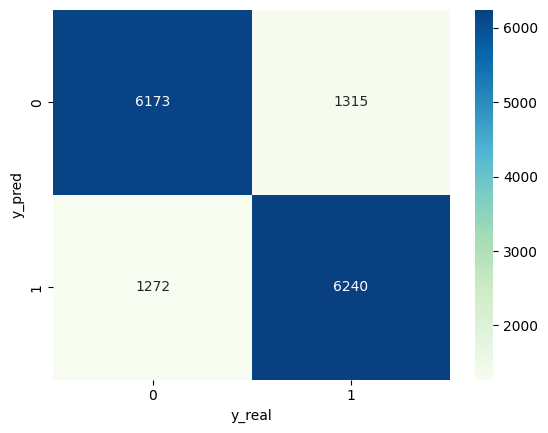

In [ ]:
#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
sentence_test, num_words = filtrarReviews(ds_cine_test, False)

#tokenizer.fit_on_texts(sentence_test.review_es.to_list())
x_test = tokenizer.texts_to_matrix(sentence_test.review_es.to_list(), mode = "count")


predict = modelo_optimizado.predict(x_test)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

269/269 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


positivo    4534
negativo    4065
Name: sentimiento, dtype: int64

Resultado de control para chequear si se esta haciendo bien

In [ ]:
predict = modelo_optimizado.predict(ds_cine_test.review_es)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    4755
negativo    3844
Name: sentimiento, dtype: int64

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,positivo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [ ]:
ds_resultados.to_csv("predicciones_red_neuronal3.csv", index = False)

##Segunda Arquitectura

###Definición de la Arquitectura

In [ ]:
def create_model():
    input_dim = (seq_train.shape[1],)
    model = keras.Sequential([
        keras.layers.Dense(32, input_shape=input_dim, activation='relu', kernel_initializer='uniform'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(32, input_shape=input_dim, activation='relu', kernel_initializer='uniform'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(32, input_shape=input_dim, activation='relu', kernel_initializer='uniform'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-41-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


### Validación Cruzada

In [ ]:
param_grid = dict(#num_filters = [32, 64, 128],
                  #kernel_size = [2, 4, 8],
                  #vocab_size = [vocab_size],
                  #embedding_dim = [64],
                  #maxlen = [num_words],
                  epochs = [4, 6, 8],
                  batch_size = [8, 16, 32, 64])

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=modelo, param_distributions=param_grid, cv=2, n_iter=1, scoring='accuracy',
                                   verbose=2, error_score='raise')

# Ajustar el modelo al conjunto de entrenamiento y encontrar el mejor conjunto de hiperparámetros
random_search.fit(seq_train, y_train_encoded)

# Imprimir el mejor conjunto de hiperparámetros y su puntuación
print("Mejor conjunto de hiperparámetros encontrado:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(random_search.best_score_)

# Obtener el modelo con los mejores hiperparámetros
modelo_optimizado = random_search.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Epoch 1/4
547/547 [==============================] - 4s 4ms/step - loss: 0.5543 - accuracy: 0.7099
Epoch 2/4
547/547 [==============================] - 4s 7ms/step - loss: 0.3895 - accuracy: 0.8480
Epoch 3/4
547/547 [==============================] - 4s 7ms/step - loss: 0.3347 - accuracy: 0.8681
Epoch 4/4
547/547 [==============================] - 1s 2ms/step
[CV] END ............................batch_size=32, epochs=4; total time=  24.5s
Epoch 1/4
547/547 [==============================] - 8s 7ms/step - loss: 0.5392 - accuracy: 0.7284
Epoch 2/4
547/547 [==============================] - 3s 6ms/step - loss: 0.3757 - accuracy: 0.8511
Epoch 3/4
547/547 [==============================] - 2s 4ms/step - loss: 0.3200 - accuracy: 0.8759
Epoch 4/4
547/547 [==============================] - 2s 3ms/step
[CV] END ............................batch_size=32, epochs=4; total time=  28.1s
Epoch 1/4
1094/1094 [==============================] - 

### Validacion de la prediccion

In [ ]:
y_pred=modelo_optimizado.predict(x_val)

# Convert integer predictions back to original labels
y_pred_original = le.inverse_transform(y_pred)

#Accuracy test
f1_score(y_test, y_pred_original, average='weighted')

469/469 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8369197085847305

              precision    recall  f1-score   support

    negativo       0.81      0.88      0.84      7488
    positivo       0.87      0.80      0.83      7512

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



Text(50.722222222222214, 0.5, 'y_pred')

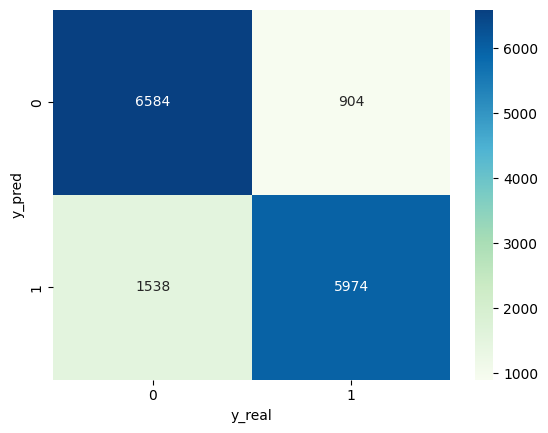

In [ ]:
#performance
print(classification_report(y_test, y_pred_original))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred_original)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [ ]:
sentence_test, num_words = filtrarReviews(ds_cine_test, False)

#tokenizer.fit_on_texts(sentence_test.review_es.to_list())
x_test = tokenizer.texts_to_matrix(sentence_test.review_es.to_list(), mode = "count")


predict = modelo_optimizado.predict(x_test)

# Convert numeric labels to string labels
predicted_labels = le.inverse_transform(predict)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predicted_labels),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

269/269 [==============================] - 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


positivo    4307
negativo    4292
Name: sentimiento, dtype: int64

Resultado de control para chequear si se esta haciendo bien

In [ ]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,positivo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,negativo


In [ ]:
ds_resultados.to_csv("predicciones_red_neuronal4.csv", index = False)

## Tercera Arquitectura Embedding WIP no Usar

### Procesamiento del dataset

In [ ]:
frasesFiltradas = []
max_num_words = 0
for index, value in ds_cine_train["review_es"].items():
  #Ponemos todas las palabras en lowercase
  value = value.lower()

  #Saco las stopwords
  valueFiltrado = [x for x in value.split() if x not in stopwords_es]
        #Vuelvo a unir el texto
  valueFiltrado = " ".join(valueFiltrado)

  #Saca los diacriticos de letras como vocales, etc (la ñ se mantiene)
  #Expresion regular obtenida de: https://es.stackoverflow.com/a/139811
  valueFiltrado = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
                                normalize( "NFD", valueFiltrado), 0, re.I)
  valueFiltrado = normalize('NFC', valueFiltrado)

  #Saco los signos de puntuacion
  #Funcion obtenida de: https://stackoverflow.com/a/266162/13683575
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', string.punctuation))
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¡'))
  valueFiltrado =  valueFiltrado.translate(str.maketrans('', '', '¿'))

  #Anadimos la frase a la lista de frases filtradas
  frasesFiltradas.append(valueFiltrado)
  if len(valueFiltrado.split()) > max_num_words :
    max_num_words = len(valueFiltrado.split())
reviewDfFiltrado = pd.DataFrame(data={'review_es':frasesFiltradas, 'sentimiento':ds_cine_train['sentimiento']})

In [ ]:
max_num_words

2353

In [ ]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = reviewDfFiltrado.drop([target], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = reviewDfFiltrado[target].copy()

sentences_train, sentences_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y,
                                                    test_size = 0.3,    #30% al conjunto de test
                                                    random_state = SEED) #estratificado para mantener proporcion

In [ ]:
sentences_train

,review_es
36322,secuela exactamente esperaras seay suficientem...
4638,bastante conocido asi pondre demasiado ella hi...
46808,cometi error comprar recojo peliculas inspirad...
38099,pelicula pelicula proverbial años 80 muestra e...
31461,encanto pelicula niñoparece puedo encontrarlo ...
...,...
39296,comence ver superficie primera vez enganchado ...
49015,me tomando peloesta posiblemente peor pelicula...
2693,haria creer juego hombre obsesionado numero se...
8076,compraria dolar comprete pelicula dolar visto...


In [ ]:
type(sentences_train)

pandas.core.frame.DataFrame

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#tokenizer = Tokenizer(num_words=5000)
num_words = max_num_words
tokenizer = Tokenizer(num_words= num_words)
tokenizer.fit_on_texts(sentences_train.review_es.to_list())
seq_train = tokenizer.texts_to_sequences(sentences_train.review_es.to_list())
#[x_train] = np.array(tokenizer.texts_to_sequences(sentences_train.review_es.to_list()))
x_val = tokenizer.texts_to_sequences(sentences_test.review_es.to_list())

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
x_train = pad_sequences(seq_train, padding='post', maxlen=num_words)
x_val = pad_sequences(x_val, padding='post', maxlen=num_words)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

### Definicion de la Arquitectura

In [ ]:
def create_model():
    model = keras.Sequential([
        #keras.layers.Embedding(input_dim= max_num_words, output_dim = 32, mask_zero= True ),
        #keras.layers.LSTM(32),
        keras.layers.Dense(num_words, activation='relu', kernel_initializer='uniform'),

        keras.layers.Dense(64, activation='relu', kernel_initializer='uniform'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.5),

        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  #loss='binary_crossentropy',
                  #metrics=['accuracy']
                  #optimizer=keras.optimizers.SGD(learning_rate = 0.001),
        loss='categorical_crossentropy',
        metrics=["accuracy"]
                  )
    return model

In [ ]:
modelo = KerasClassifier(build_fn=create_model, verbose=1)

<ipython-input-45-a75bf645cdf9>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasClassifier(build_fn=create_model, verbose=1)


In [ ]:
modelo.fit(x_train_scaled, y_train_encoded, epochs = 64, batch_size= 8)

Epoch 1/64
4375/4375 [==============================] - 351s 79ms/step - loss: 1.1468 - accuracy: 0.5001
Epoch 2/64
4375/4375 [==============================] - 335s 77ms/step - loss: 0.7217 - accuracy: 0.5010
Epoch 3/64
4375/4375 [==============================] - 336s 77ms/step - loss: 0.8141 - accuracy: 0.4987
Epoch 4/64
4375/4375 [==============================] - 335s 76ms/step - loss: 0.6972 - accuracy: 0.4942
Epoch 5/64
4375/4375 [==============================] - 333s 76ms/step - loss: 0.6945 - accuracy: 0.5015
Epoch 6/64
4375/4375 [==============================] - 334s 76ms/step - loss: 0.6933 - accuracy: 0.4996
Epoch 7/64
4375/4375 [==============================] - 339s 77ms/step - loss: 0.6934 - accuracy: 0.5053
Epoch 8/64
4375/4375 [==============================] - 329s 75ms/step - loss: 0.6933 - accuracy: 0.4943
Epoch 9/64
4375/4375 [==============================] - 323s 74ms/step - loss: 0.7054 - accuracy: 0.4995
Epoch 10/64
4375/4375 [==============================] 

KeyboardInterrupt: ignored



---



#Modelo de Ensamble Híbrido

##Primer modelo(ensamble de 3 modelos)

Para este primer ensamble, utilizaremos un modelo de Bayes Naive, un Random Forest, y un XGBoost. Los modelos elegidos fueron los que dieron mejor score en la competencia de Kaggle.

In [15]:
ensamble = VotingClassifier(estimators = [('nb', Pipeline(steps=[
        ('tfidfvectorizer', TfidfVectorizer( stop_words='english',
                                             )),
        ('multinomialnb', MultinomialNB(alpha = 1,
                                        fit_prior = False,
                                        class_prior= [0.2, 0.8]))
    ])),
                               ('rf', Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer(

    )),
    ('gsrf', RandomForestClassifier(
        class_weight="balanced",
        oob_score=True,
        n_estimators=80,
        min_samples_split=50,
        min_samples_leaf=15,
        max_depth=28,
        criterion='gini',
        bootstrap=True

    ))
  ])),
                               ('xgb', Pipeline(steps=[
    ('tfidfvectorizer', TfidfVectorizer()),
    ('xgboost_model', XGBClassifier(n_estimators=190,
                                    max_depth=6,
                                    colsample_bytree=0.6,
                                    learning_rate=0.3,
                                    gamma = 0.15000000000000002,
                                    reg_alpha=0.0,
                                    reg_lambda=0.1,
                                    subsample=1.0,
                                    )),
  ]))
])

ensamble.fit(x_train.review_es, y_train)

VotingClassifier(estimators=[('nb',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer(stop_words='english')),
                                              ('multinomialnb',
                                               MultinomialNB(alpha=1,
                                                             class_prior=[0.2,
                                                                          0.8],
                                                             fit_prior=False))])),
                             ('rf',
                              Pipeline(steps=[('tfidfvectorizer',
                                               TfidfVectorizer()),
                                              ('gsrf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=28,
                                                                      min_samples_leaf=15,
                                                                      min_samples...
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=0.3,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=190,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None, ...))]))])

In [17]:
y_pred = ensamble.predict(x_test.review_es)

#Accuracy test
f1_score(y_test, y_pred, pos_label='positivo')

0.8480686695278971

              precision    recall  f1-score   support

    negativo       0.91      0.75      0.82      7500
    positivo       0.79      0.92      0.85      7500

    accuracy                           0.83     15000
   macro avg       0.85      0.83      0.83     15000
weighted avg       0.85      0.83      0.83     15000



Text(50.722222222222214, 0.5, 'y_pred')

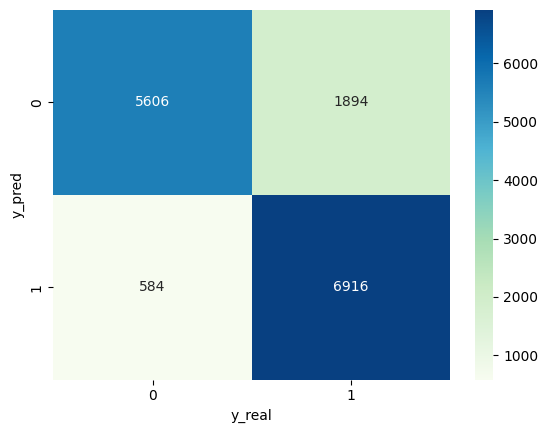

In [18]:
y_pred = ensamble.predict(x_test.review_es)

#performance
print(classification_report(y_test, y_pred))

#Creamos la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.xlabel('y_real')
plt.ylabel('y_pred')

###Predicción sobre el dataset test

In [19]:
predict = ensamble.predict(ds_cine_test.review_es)

ds_resultados = pd.DataFrame(zip(ds_cine_test["ID"], predict),columns = ['ID','sentimiento'])

ds_resultados['sentimiento'].value_counts()

positivo    5901
negativo    2698
Name: sentimiento, dtype: int64

In [20]:
ds_resultados_copy_csv = ds_resultados.copy()
ds_resultados_copy_csv.set_index("ID", inplace = True)
ds_resultados_copy_csv

,sentimiento
ID,
60000,negativo
60001,negativo
60002,negativo
60003,negativo
60004,negativo
...,...
68594,positivo
68595,negativo
68596,positivo


In [21]:
ds_resultados.to_csv("predicciones_ensamble1.csv", index = False)